In [1]:
from model_and_circuit import *

### Target Distribution

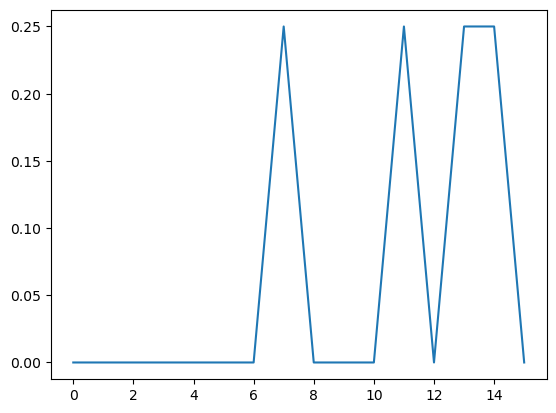

In [ ]:
with open("/home/akashm/PROJECT/qcbm_hiwi/qcbm_project/cat_anticat/data/three_particle_distribution.pkl", "rb") as f:
    target_distribution = pickle.load(f)
    
x = np.arange(0,2**n_qubits)
plt.plot(x,target_distribution,)

### Loss Function

In [3]:
from functools import partial

class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return (px @ self.K @ py)
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy) 
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        loss = (self.mmd(px[0],self.py)) #+ 1*jnp.log10(pnumber_distribution(px[1],n_qubits)[1])**2)
        return loss, px
    

#Model Training
@partial(jax.jit, static_argnames=['qcbm'])
def update_step(params,opt_state,qcbm):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs1 = jnp.asarray(qcbm_probs[0], dtype=jnp.float64)
    qcbm_probs2 = jnp.asarray(qcbm_probs[1], dtype=jnp.float64)
    
    kl_div = (
        -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(qcbm_probs1) - jnp.log(target_distribution))) 
        #+ 1*jnp.log10(pnumber_distribution(qcbm_probs2,n_qubits)[1])**2
        )
    
    return params, opt_state, loss_val, kl_div


### Running the model

In [4]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**n_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)

# lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.01,staircase=True)
lr = 0.1
opt = optax.adam(learning_rate=lr)


def run_model(folds_range):
    
    #Array to save all the anticat distributions
    anticats = []
    
    #For loop to run the model for different number of folds
    for folds in folds_range:
        print("Running for folds: ",folds)

        # # Initialize a JAX random key
        key = jax.random.PRNGKey(0)
        # # Generate initial parameters as a JAX array
        initial_params = jax.random.uniform(key, shape=(folds, (3 * total_qubits)), minval=0.0, maxval=1.0)
        
        ## Initializing the arrays to store the results
        history = []
        divs = []
        parameters = []
        kl_div = 1

        ## Initializing the model
        qcbm = QCBM(lambda params: circuit(params, folds=folds), mmd=mmd, py=target_distribution)
        weights = initial_params
        n_epochs = 1001
        opt_state = opt.init(weights)
        i = 0
        
        start_time = time.time()
        while i < n_epochs:
            i+=1
            current_lr = lr
            weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state,qcbm=qcbm)
                  
            history.append(loss_val)
            divs.append(kl_div)
            parameters.append(weights)
        end_time = time.time()
        
        print(f"The minimum KL divergence obtained for {folds} folds : {min(divs)} in {n_epochs} epochs in {end_time-start_time} seconds")
        
        ## Obtaining the Anticat distribution
        optimal_params = parameters[np.argmin(divs)]
        qcbm_probs = circuit(optimal_params,folds=folds)
        
        anticats.append(qcbm_probs[1])
    
    return anticats
                

In [5]:
folds_range = [2,3,4,5,6,7,8,9,10]
anticats = run_model(folds_range)

Running for folds:  2
The minimum KL divergence obtained for 2 folds : 0.135801762342453 in 1001 epochs in 15.2917799949646 seconds
Running for folds:  3
The minimum KL divergence obtained for 3 folds : 0.0015529990196228027 in 1001 epochs in 16.426246166229248 seconds
Running for folds:  4
The minimum KL divergence obtained for 4 folds : 0.0009916722774505615 in 1001 epochs in 22.038323163986206 seconds
Running for folds:  5
The minimum KL divergence obtained for 5 folds : 0.0009252727031707764 in 1001 epochs in 29.324236392974854 seconds
Running for folds:  6
The minimum KL divergence obtained for 6 folds : 0.0010733604431152344 in 1001 epochs in 36.219156980514526 seconds
Running for folds:  7
The minimum KL divergence obtained for 7 folds : 0.0013820528984069824 in 1001 epochs in 42.941848278045654 seconds
Running for folds:  8
The minimum KL divergence obtained for 8 folds : 0.001055598258972168 in 1001 epochs in 54.075023889541626 seconds
Running for folds:  9
The minimum KL dive

In [1]:
## Get the average anticat distribution from all anticat distributions from anticats array
anticats = np.array(anticats)
average_anticat = np.mean(anticats,axis=0)
x = np.arange(0,2**n_qubits)
plt.plot(x,average_anticat,label="Average Anticat")
plt.xlabel("Hilbert Space")
plt.ylabel("Probability")
plt.title("Average Anticat Distribution")
plt.show()


NameError: name 'np' is not defined

In [9]:
with open("/home/akashm/PROJECT/qcbm_hiwi/qcbm_project/cat_anticat/data/three_particle_avg_anticat_distribution.pkl", "wb") as f:
    pickle.dump(average_anticat, f)
    
print("Average Anticat distribution saved successfully")

Average Anticat distribution saved successfully


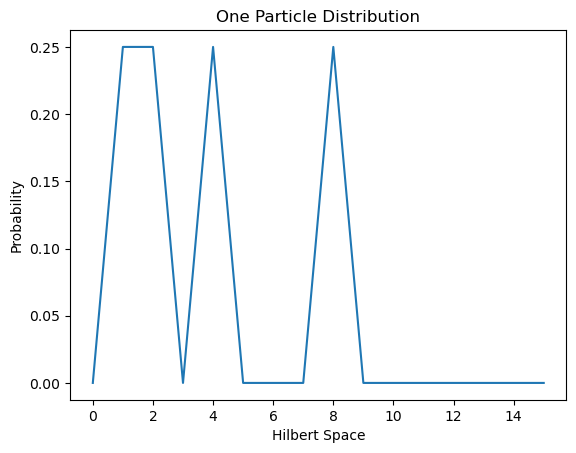

In [10]:
def one_particle_distribution(n_qubits,x_array):
    """
    Generate a probability distribution where only bitstrings with exactly 3 ones 
    have nonzero probability for an arbitrary n-qubit system.
    
    Parameters:
    - n_qubits: int, total number of qubits
    
    Returns:
    - distribution: JAX array with probability values
    """
    assert n_qubits >= 1, "Number of qubits must be at least 3 to have 3-particle states."

    # Get all bit positions where exactly 3 bits are 1
    valid_indices = [sum(1 << i for i in comb) for comb in combinations(range(n_qubits), 1)]
    
    # Create a zero-initialized probability distribution for 2^n states
    distribution = jnp.zeros(2**n_qubits, dtype=jnp.float64)

    # Assign equal probability to valid states
    distribution = distribution.at[jnp.array(valid_indices)].set(1.0 / len(valid_indices))
    area = trapezoid(distribution,x_array)
    distribution /= area
    return distribution

plt.plot(x,one_particle_distribution(n_qubits,x))
plt.xlabel("Hilbert Space")
plt.ylabel("Probability")
plt.title("One Particle Distribution")
plt.show()

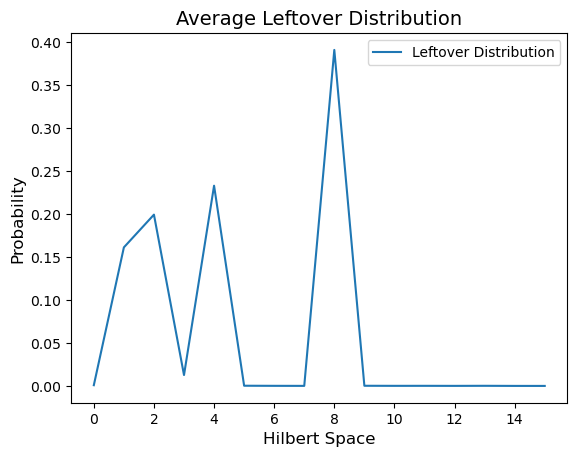

In [4]:
with open("/home/akashm/PROJECT/qcbm_hiwi/qcbm_project/cat_anticat/data/three_particle_avg_anticat_distribution.pkl", "rb") as f:
    target_distribution = pickle.load(f)
    
x = np.arange(0,2**n_qubits)
plt.plot(x,target_distribution,label="Leftover Distribution")
plt.xlabel("Hilbert Space",fontsize=12)
plt.ylabel("Probability",fontsize=12)
plt.title("Average Leftover Distribution",fontsize=14)
plt.legend()
plt.show()